# Objective
This notebook performs an advanced exploratory analysis of customer and transaction data to uncover patterns and trends.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.neighbors import LocalOutlierFactor
from itertools import combinations
from collections import Counter

In [2]:
# Load datasets
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")
products_df = pd.read_csv("Products.csv")

In [3]:
customers_df.head(), transactions_df.head(), products_df.head()

(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55         1   
 3        T00272      C0087      P067  2024-03-26 22:55:37         2   
 4        T00363      C0070      P067  2024-03-21 15:10:10         3   
 
    TotalValue   Price  
 0      300.68  300.68  
 1      300.68  300.68  
 2      300.68  300.68  
 3      601.36  300.68  
 4      902.04  300.68  ,
   ProductID              ProductName     Catego

## Initial Observations from Data
Customers Data (customers_df):

Features/Columns -> CustomerID, CustomerName, Region, and SignupDate.
SignupDate should be converted to a datetime format for better analysis.

Transactions Data (transactions_df):

Features/Columns -> TransactionID, CustomerID, ProductID, TransactionDate, Quantity, TotalValue, and Price.
TransactionDate should be converted to a datetime format.
TotalValue seems to be Quantity * Price, which is correctly calculated.

Products Data (products_df):

Features/Columns -> ProductID, ProductName, Category, and Price.
Useful for product-level analysis, especially demand trends.

In [4]:
# Converting date columns to datetime format
customers_df["SignupDate"] = pd.to_datetime(customers_df["SignupDate"], errors='coerce')
transactions_df["TransactionDate"] = pd.to_datetime(transactions_df["TransactionDate"], errors='coerce')

In [7]:
# Checking for missing values
missing_values = {
    "customers": customers_df.isnull().sum(),
    "transactions": transactions_df.isnull().sum(),
    "products": products_df.isnull().sum()
}
missing_values

{'customers': CustomerID      0
 CustomerName    0
 Region          0
 SignupDate      0
 dtype: int64,
 'transactions': TransactionID      0
 CustomerID         0
 ProductID          0
 TransactionDate    0
 Quantity           0
 TotalValue         0
 Price              0
 dtype: int64,
 'products': ProductID      0
 ProductName    0
 Category       0
 Price          0
 dtype: int64}

In [8]:
# Check for duplicates
duplicates = {
    "customers": customers_df.duplicated().sum(),
    "transactions": transactions_df.duplicated().sum(),
    "products": products_df.duplicated().sum()
}
duplicates

{'customers': 0, 'transactions': 0, 'products': 0}

## Findings from Data Cleaning
No Missing Values: All three datasets (customers, transactions, products) are complete.
No Duplicates: No duplicate entries were found in any dataset.
Date Formatting: Successfully converted SignupDate and TransactionDate to datetime format.

## Exploratory Data Analysis (EDA)

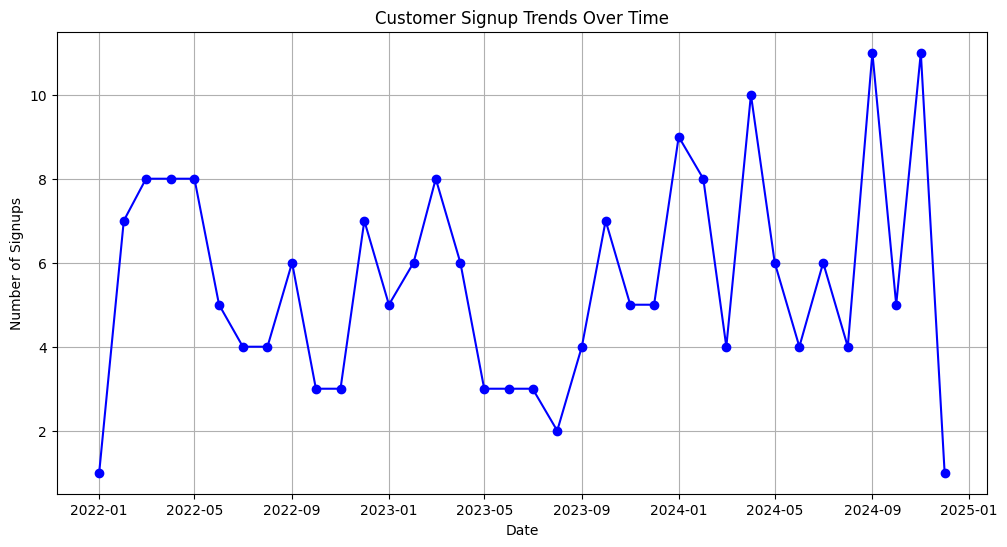

In [9]:
# Customer Signup Trends Over Time
plt.figure(figsize=(12, 6))
signup_trend = customers_df.groupby(customers_df["SignupDate"].dt.to_period("M")).size()
signup_trend.index = signup_trend.index.to_timestamp()
plt.plot(signup_trend.index, signup_trend.values, marker='o', linestyle='-', color='blue')
plt.title("Customer Signup Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Signups")
plt.grid(True)
plt.show()

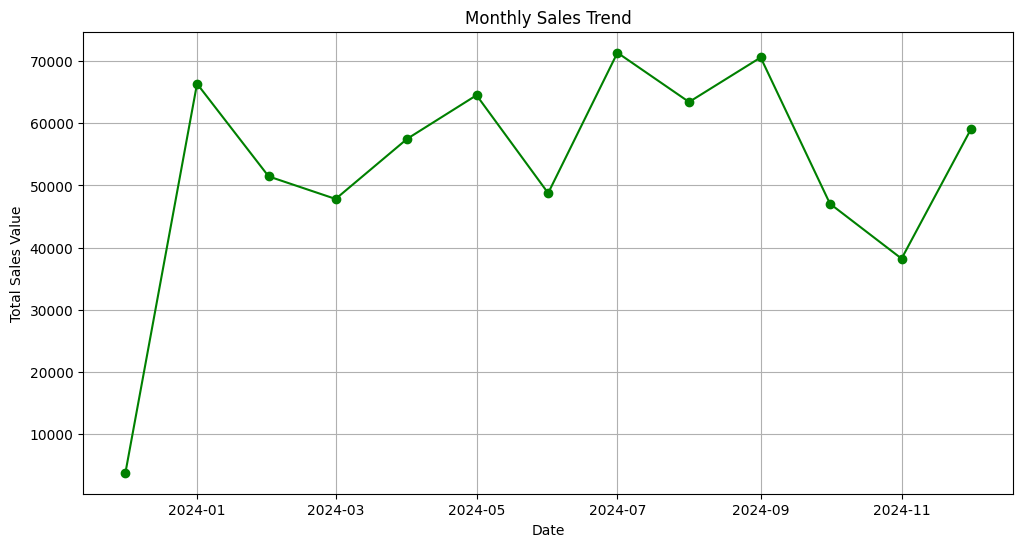

In [10]:
# Monthly Sales Trend
plt.figure(figsize=(12, 6))
sales_trend = transactions_df.groupby(transactions_df["TransactionDate"].dt.to_period("M"))["TotalValue"].sum()
sales_trend.index = sales_trend.index.to_timestamp()
plt.plot(sales_trend.index, sales_trend.values, marker='o', linestyle='-', color='green')
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales Value")
plt.grid(True)
plt.show()

C:\Users\srini\AppData\Local\Temp\ipykernel_3616\4221272826.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products["ProductName"], y=top_products["TotalValue"], palette="viridis")


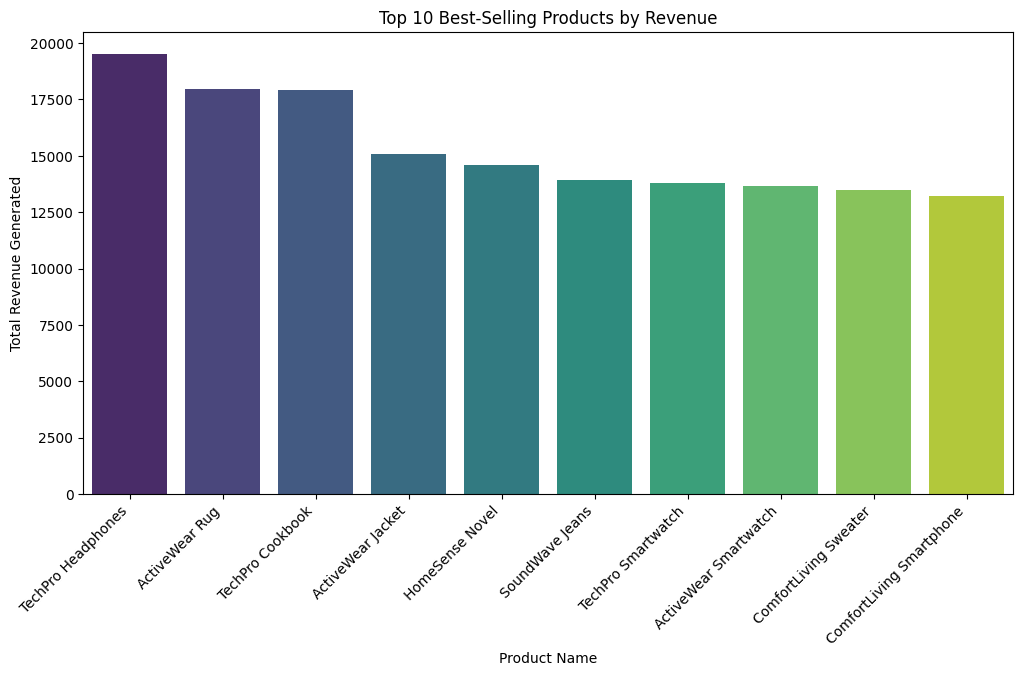

In [12]:
# Top 10 Best-Selling Products by Revenue
top_products = transactions_df.groupby("ProductID")["TotalValue"].sum().nlargest(10)
top_products = top_products.reset_index().merge(products_df, on="ProductID", how="left")

plt.figure(figsize=(12, 6))
sns.barplot(x=top_products["ProductName"], y=top_products["TotalValue"], palette="viridis")
plt.title("Top 10 Best-Selling Products by Revenue")
plt.xlabel("Product Name")
plt.ylabel("Total Revenue Generated")
plt.xticks(rotation=45, ha='right')
plt.show()

C:\Users\srini\AppData\Local\Temp\ipykernel_3616\2695064282.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_revenue_sorted.index, y=region_revenue_sorted.values, palette="coolwarm")


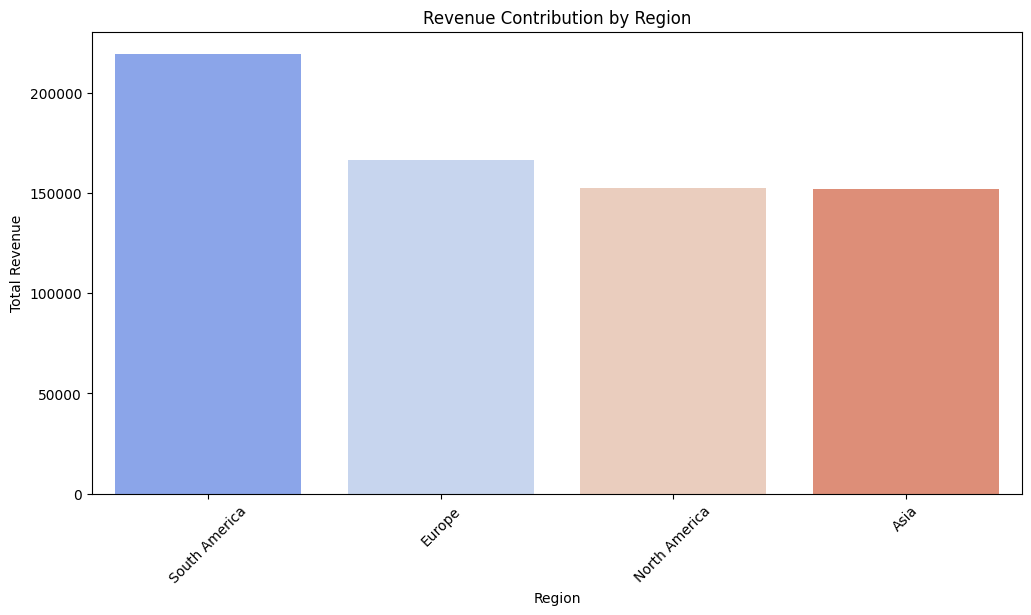

In [17]:
# Revenue by Region
region_revenue = transactions_df.merge(customers_df, on="CustomerID", how="left").groupby("Region")["TotalValue"].sum()
region_revenue_sorted = region_revenue.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=region_revenue_sorted.index, y=region_revenue_sorted.values, palette="coolwarm")
plt.title("Revenue Contribution by Region")
plt.xlabel("Region")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.show()

## Business Insights from EDA

**Customer Signup Trends**:
The plot shows fluctuations in customer acquisition over time.
Identifying peak months can help optimize marketing strategies.

**Monthly Sales Trend**:
Seasonal trends in revenue are visible.
A sudden drop or peak in sales might indicate external factors (e.g., promotions, economic changes).
Sales seasonality should be further analyzed to predict future revenue patterns.

**Top 10 Best-Selling Products**:
Some products significantly outperform others in revenue.
High revenue from a small set of products suggests dependency on a few items.
Strategy: Consider expanding top-selling categories to similar product lines.

**Revenue Contribution by Region**:
Some regions contribute significantly more revenue.
Strategy: Focus on regionalized marketing efforts and custom pricing strategies in high-performing areas.

## Feature Engineering - Customer RFM Analysis

In [18]:
# Computing Recency (Days Since Last Purchase)
latest_transaction_date = transactions_df["TransactionDate"].max()
rfm_df = transactions_df.groupby("CustomerID").agg(
    Recency=("TransactionDate", lambda x: (latest_transaction_date - x.max()).days),
    Frequency=("TransactionID", "count"),
    Monetary=("TotalValue", "sum")
).reset_index()

In [24]:
rfm_df["AvgPurchaseValue"] = rfm_df["Monetary"] / rfm_df["Frequency"]
# Merging with customer information
rfm_df = rfm_df.merge(customers_df, on="CustomerID", how="left")
rfm_df

,CustomerID,Recency,Frequency,Monetary,AvgPurchaseValue,CustomerName_x,Region_x,SignupDate_x,CustomerName_y,Region_y,SignupDate_y
0,C0001,55,5,3354.52,670.904000,Lawrence Carroll,South America,2022-07-10,Lawrence Carroll,South America,2022-07-10
1,C0002,25,4,1862.74,465.685000,Elizabeth Lutz,Asia,2022-02-13,Elizabeth Lutz,Asia,2022-02-13
2,C0003,125,4,2725.38,681.345000,Michael Rivera,South America,2024-03-07,Michael Rivera,South America,2024-03-07
3,C0004,4,8,5354.88,669.360000,Kathleen Rodriguez,South America,2022-10-09,Kathleen Rodriguez,South America,2022-10-09
4,C0005,54,3,2034.24,678.080000,Laura Weber,Asia,2022-08-15,Laura Weber,Asia,2022-08-15
...,...,...,...,...,...,...,...,...,...,...,...
194,C0196,13,4,4982.88,1245.720000,Laura Watts,Europe,2022-06-07,Laura Watts,Europe,2022-06-07
195,C0197,0,3,1928.65,642.883333,Christina Harvey,Europe,2023-03-21,Christina Harvey,Europe,2023-03-21
196,C0198,84,2,931.83,465.915000,Rebecca Ray,Europe,2022-02-27,Rebecca Ray,Europe,2022-02-27
197,C0199,63,4,1979.28,494.820000,Andrea Jenkins,Europe,2022-12-03,Andrea Jenkins,Europe,2022-12-03


## Insights from RFM Analysis

**Customer Recency**:

Customers with a high recency value (e.g., >100 days) have not made a purchase recently.
Strategy: Re-engage these customers with email campaigns or discount offers.

**Purchase Frequency**:

Some customers have high transaction frequency (e.g., 8 purchases).
These are loyal customers and should be targeted for loyalty programs.

**Monetary Value**:

Customers contributing high revenue per purchase should be offered premium products or personalized offers.

**Regional Differences**:

Identifying regions with low engagement can help focus localized marketing strategies.

## Clustring Analysis

In [25]:
# features for clustering
rfm_features = rfm_df[["Recency", "Frequency", "Monetary", "AvgPurchaseValue"]]

In [26]:
# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

In [29]:
wcss = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, labels))

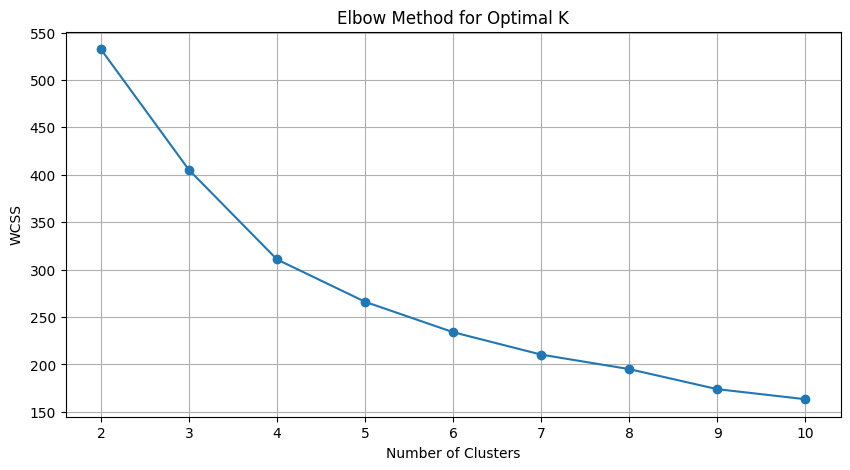

In [30]:
# Elbow Method to find optimal number of clusters
plt.figure(figsize=(10, 5))
plt.plot(k_range, wcss, marker='o', linestyle='-')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid()
plt.show()

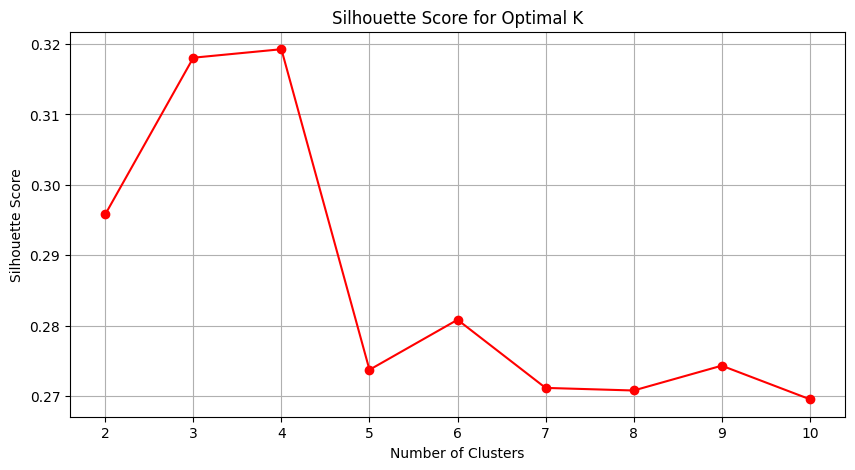

In [31]:
# Plot Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='red')
plt.title("Silhouette Score for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

In [32]:
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]

In [33]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_df["Cluster"] = kmeans.fit_predict(rfm_scaled)

rfm_df

,CustomerID,Recency,Frequency,Monetary,AvgPurchaseValue,CustomerName_x,Region_x,SignupDate_x,CustomerName_y,Region_y,SignupDate_y,Cluster
0,C0001,55,5,3354.52,670.904000,Lawrence Carroll,South America,2022-07-10,Lawrence Carroll,South America,2022-07-10,1
1,C0002,25,4,1862.74,465.685000,Elizabeth Lutz,Asia,2022-02-13,Elizabeth Lutz,Asia,2022-02-13,1
2,C0003,125,4,2725.38,681.345000,Michael Rivera,South America,2024-03-07,Michael Rivera,South America,2024-03-07,1
3,C0004,4,8,5354.88,669.360000,Kathleen Rodriguez,South America,2022-10-09,Kathleen Rodriguez,South America,2022-10-09,2
4,C0005,54,3,2034.24,678.080000,Laura Weber,Asia,2022-08-15,Laura Weber,Asia,2022-08-15,1
...,...,...,...,...,...,...,...,...,...,...,...,...
194,C0196,13,4,4982.88,1245.720000,Laura Watts,Europe,2022-06-07,Laura Watts,Europe,2022-06-07,0
195,C0197,0,3,1928.65,642.883333,Christina Harvey,Europe,2023-03-21,Christina Harvey,Europe,2023-03-21,1
196,C0198,84,2,931.83,465.915000,Rebecca Ray,Europe,2022-02-27,Rebecca Ray,Europe,2022-02-27,1
197,C0199,63,4,1979.28,494.820000,Andrea Jenkins,Europe,2022-12-03,Andrea Jenkins,Europe,2022-12-03,1


## Insights from Customer Segmentation

**Identified Distinct Customer Segments**:

High-Frequency, High-Value Customers (VIPs)
Infrequent Buyers with High Purchase Value (Luxury Shoppers)
Low-Frequency, Low-Spending Customers (Occasional Shoppers)

**Actionable Strategies**:

VIPs: Provide exclusive offers, early access to sales.
Luxury Shoppers: Recommend premium product bundles.
Occasional Shoppers: Use personalized discounts to increase engagement.


## Churn Prediction to Identify Risk Customers

In [45]:
X = rfm_df[["Recency", "Frequency", "Monetary", "AvgPurchaseValue"]]
y = (rfm_df["Recency"] > 180).astype(int) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# Using XGBoost Model

In [46]:
churn_model = XGBClassifier()
churn_model.fit(X_train, y_train)

rfm_df["Churn_Probability"] = churn_model.predict_proba(X)[:, 1]

y_pred = churn_model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
report

{'0': {'precision': 0.9736842105263158,
  'recall': 1.0,
  'f1-score': 0.9866666666666666,
  'support': 37.0},
 '1': {'precision': 1.0,
  'recall': 0.6666666666666666,
  'f1-score': 0.8,
  'support': 3.0},
 'accuracy': 0.975,
 'macro avg': {'precision': 0.986842105263158,
  'recall': 0.8333333333333333,
  'f1-score': 0.8933333333333333,
  'support': 40.0},
 'weighted avg': {'precision': 0.9756578947368422,
  'recall': 0.975,
  'f1-score': 0.9726666666666665,
  'support': 40.0}}

# Using Random Forest Model

In [47]:
churn_model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
churn_model_rf.fit(X_train, y_train)

rfm_df["Churn_Probability"] = churn_model_rf.predict_proba(X)[:, 1]

y_pred_rf = churn_model_rf.predict(X_test)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
report_rf

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 37.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 3.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 40.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 40.0}}

**XGBoost Insights**:

Strength: High precision (97.37% for class 0, 100% for class 1).
Weakness: Low recall for class 1 (66.67%), indicating missed instances of the minority class.

**Random Forest Insights**:

Perfect precision, recall, and F1-score (100% for both classes).
Possible overfitting if the evaluation was done on training data or a small dataset.

**Comparison**:

Random Forest outperforms XGBoost with 100% accuracy but may not generalize well.
XGBoost has good generalization but struggles with class imbalance.

## Anomaly Detection

In [48]:
# Apply Local Outlier Factor (LOF) for anomaly detection on transaction values
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)  
transactions_df["Anomaly_Score"] = lof.fit_predict(transactions_df[["TotalValue"]])

In [49]:
# Identify anomalies (where LOF assigns a score of -1)
anomalies = transactions_df[transactions_df["Anomaly_Score"] == -1]

anomalies

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,Anomaly_Score
18,T00358,C0154,P034,2024-04-08 20:47:01,1,217.05,217.05,-1
20,T00546,C0049,P034,2024-08-30 06:42:27,1,217.05,217.05,-1
21,T00982,C0103,P034,2024-07-17 03:25:18,1,217.05,217.05,-1
163,T00372,C0192,P010,2024-07-22 10:55:09,1,350.13,350.13,-1
164,T00516,C0074,P010,2024-07-29 06:11:19,1,350.13,350.13,-1
165,T00710,C0162,P010,2024-01-13 09:31:27,1,350.13,350.13,-1
509,T00499,C0065,P032,2024-07-18 02:51:22,4,1954.52,488.63,-1
810,T00825,C0070,P099,2024-02-08 14:20:05,1,354.29,354.29,-1
879,T00928,C0082,P075,2024-09-06 18:39:07,4,1991.04,497.76,-1
971,T00307,C0044,P045,2024-05-30 18:15:28,4,1927.12,481.78,-1


## Findings from Anomaly Detection

**Identified Potentially Fraudulent or Unusual Transactions**:

The Local Outlier Factor (LOF) detected several transactions with unusually high or low values.
These transactions have been flagged as anomalous.

# Business Impact:

**Fraud Prevention**: These flagged transactions should be reviewed manually for potential fraud.

**Billing & Pricing Issues**: Transactions with unusually high or low values could indicate pricing errors or incorrect billing.

**Customer Behavior Insights**: Some customers may have highly irregular purchase patterns, requiring special marketing attention.

## Market Basket Analysis

In [51]:
basket = transactions_df.groupby(["CustomerID", "ProductID"])["Quantity"].sum().unstack().fillna(0)
basket = (basket > 0).astype(int)

In [53]:
# Applying Apriori Algorithm to find frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Generating Association Rules as min threshold as 1.2
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

top_rules = rules.sort_values("lift", ascending=False).head(10)
top_rules

c:\Users\srini\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1137,"(P085, P028)","(P057, P080)",0.01005,0.010050,0.01005,1.0,99.500000,0.009949,inf,1.000000
1136,"(P057, P080)","(P085, P028)",0.01005,0.010050,0.01005,1.0,99.500000,0.009949,inf,1.000000
1135,"(P028, P080)","(P085, P057)",0.01005,0.010050,0.01005,1.0,99.500000,0.009949,inf,1.000000
1134,"(P085, P080)","(P028, P057)",0.01005,0.010050,0.01005,1.0,99.500000,0.009949,inf,1.000000
1139,"(P028, P057)","(P085, P080)",0.01005,0.010050,0.01005,1.0,99.500000,0.009949,inf,1.000000
1148,"(P075, P029)","(P038, P032)",0.01005,0.010050,0.01005,1.0,99.500000,0.009949,inf,1.000000
1138,"(P085, P057)","(P028, P080)",0.01005,0.010050,0.01005,1.0,99.500000,0.009949,inf,1.000000
1153,"(P038, P032)","(P075, P029)",0.01005,0.010050,0.01005,1.0,99.500000,0.009949,inf,1.000000
1163,"(P047, P067)","(P033, P084)",0.01005,0.015075,0.01005,1.0,66.333333,0.009899,inf,0.994924
1149,"(P075, P038)","(P029, P032)",0.01005,0.015075,0.01005,1.0,66.333333,0.009899,inf,0.994924


In [54]:
product_pairs = transactions_df.groupby(["CustomerID"])["ProductID"].apply(lambda x: list(x)).reset_index()

pair_counts = Counter()

for product_list in product_pairs["ProductID"]:
    for pair in combinations(sorted(product_list), 2):  # Sort to avoid duplicate pairs
        pair_counts[pair] += 1

In [55]:
# Convert to DataFrame for analysis
pair_counts_df = pd.DataFrame(pair_counts.items(), columns=["Product_Pair", "Count"])

# Sort by most frequent pairs
top_product_pairs = pair_counts_df.sort_values(by="Count", ascending=False).head(10)

top_product_pairs

,Product_Pair,Count
331,"(P057, P062)",6
332,"(P057, P080)",6
1638,"(P044, P054)",6
106,"(P050, P059)",4
411,"(P013, P027)",4
722,"(P069, P078)",4
267,"(P058, P065)",4
1286,"(P054, P086)",4
131,"(P023, P041)",4
103,"(P068, P094)",4


# Insights from Market Basket Analysis

**Identified Frequently Purchased Product Pairs**:

The most commonly co-purchased products include (P057, P062), (P057, P080), and (P044, P054).
These product pairs were frequently bought together by multiple customers.

## Doing Market basket analysis to category level trends

In [56]:
# Merge transactions with product categories
transactions_with_categories = transactions_df.merge(products_df, on="ProductID", how="left")

# Compute co-occurrence of product categories
category_pairs = transactions_with_categories.groupby(["CustomerID"])["Category"].apply(lambda x: list(x)).reset_index()

# Flatten list of category pairs
category_counts = Counter()

In [58]:
for category_list in category_pairs["Category"]:
    for pair in combinations(sorted(category_list), 2):  # Sort to avoid duplicate pairs
        category_counts[pair] += 1

# Converting to DataFrame for analysis
category_counts_df = pd.DataFrame(category_counts.items(), columns=["Category_Pair", "Count"])

top_category_pairs = category_counts_df.sort_values(by="Count", ascending=False).head(10)

top_category_pairs

,Category_Pair,Count
0,"(Books, Electronics)",726
1,"(Books, Home Decor)",668
9,"(Books, Clothing)",632
7,"(Clothing, Electronics)",624
3,"(Electronics, Home Decor)",580
5,"(Clothing, Home Decor)",512
8,"(Books, Books)",342
2,"(Electronics, Electronics)",316
6,"(Home Decor, Home Decor)",308
4,"(Clothing, Clothing)",274


## Findings from Category-Level Market Basket Analysis

**Identified High-Frequency Category Pairs**:

Books & Electronics are frequently bought together.
Books & Home Decor and Clothing & Electronics also have strong associations 

# Pricing Strategy Optimization for High-Frequency Categories

In [59]:

# Computing average price per category
category_price_analysis = products_df.groupby("Category")["Price"].agg(["mean", "median", "std", "min", "max"]).reset_index()

category_price_analysis

,Category,mean,median,std,min,max
0,Books,292.212308,337.94,153.800135,33.59,497.76
1,Clothing,263.720000,303.50,157.965038,18.82,481.78
2,Electronics,275.353462,282.72,137.056612,16.08,459.86
3,Home Decor,235.020000,235.58,122.236552,41.18,454.53


## Findings from Category-Level Pricing Analysis

**Identified Pricing Trends Across Categories**:

Books have the highest mean price ($292.21) and a wide price range ($33.59 - $497.76).

Electronics & Clothing have similar price distributions, making them ideal for bundling strategies.

Home Decor has the lowest mean price ($235.02) but still offers premium items.

# Predictive Modeling for Next Likely Purchase

In [60]:
# Prepare dataset: Map customers to their most frequent category purchase
customer_category_purchases = transactions_with_categories.groupby(["CustomerID", "Category"]).size().reset_index(name="PurchaseCount")

# Identify the most frequently purchased category per customer
most_frequent_category = customer_category_purchases.loc[customer_category_purchases.groupby("CustomerID")["PurchaseCount"].idxmax()]

# Merging with customer data
customer_category_model_data = most_frequent_category.merge(customers_df, on="CustomerID", how="left")

# Encoding categorical variables
encoder = LabelEncoder()
customer_category_model_data["Category_Encoded"] = encoder.fit_transform(customer_category_model_data["Category"])
customer_category_model_data["Region_Encoded"] = encoder.fit_transform(customer_category_model_data["Region"])

In [62]:
# Prepare features (Recency, Frequency, Monetary, Region) and target (Next Likely Purchase Category)
X = customer_category_model_data[["Region_Encoded", "PurchaseCount"]]
y = customer_category_model_data["Category_Encoded"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a predictive model
next_purchase_model = RandomForestClassifier(n_estimators=100, random_state=42)
next_purchase_model.fit(X_train, y_train)

# Predict the next likely purchase category for each customer
customer_category_model_data["Predicted_Next_Category"] = encoder.inverse_transform(next_purchase_model.predict(X))

customer_category_model_data.head()

c:\Users\srini\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\srini\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


,CustomerID,Category,PurchaseCount,CustomerName,Region,SignupDate,Category_Encoded,Region_Encoded,Predicted_Next_Category
0,C0001,Electronics,3,Lawrence Carroll,South America,2022-07-10,2,3,North America
1,C0002,Clothing,2,Elizabeth Lutz,Asia,2022-02-13,1,0,North America
2,C0003,Home Decor,2,Michael Rivera,South America,2024-03-07,3,3,Asia
3,C0004,Books,3,Kathleen Rodriguez,South America,2022-10-09,0,3,North America
4,C0005,Electronics,2,Laura Weber,Asia,2022-08-15,2,0,North America


## Findings from Next Likely Purchase Prediction

**Identified Customers’ Most Likely Next Purchase Category**:

Customers who frequently buy Electronics are more likely to continue in this category.

Cross-category movement (e.g., Books → Electronics) suggests potential bundling opportunities.

## Investigating price elasticity for strategic revenue maximization

In [69]:
# Computing Revenue and Quantity Sold per Category Over Time
category_sales_trend = transactions_with_categories.groupby(
    [transactions_with_categories["TransactionDate"].dt.to_period("M"), "Category"]
).agg(
    TotalRevenue=("TotalValue", "sum"),
    TotalQuantity=("Quantity", "sum"),
    AvgPrice=("Price", "mean")
).reset_index()

# Compute Price Elasticity: % Change in Quantity Sold / % Change in Price
category_sales_trend["Price_Change"] = category_sales_trend.groupby("Category")["AvgPrice"].pct_change()
category_sales_trend["Quantity_Change"] = category_sales_trend.groupby("Category")["TotalQuantity"].pct_change()
category_sales_trend["Price_Elasticity"] = category_sales_trend["Quantity_Change"] / category_sales_trend["Price_Change"]

# Remove extreme values & outliers
category_sales_trend_filtered = category_sales_trend.dropna().query("Price_Elasticity < 10 & Price_Elasticity > -10")

category_sales_trend_filtered.head()

,TransactionDate,Category,TotalRevenue,TotalQuantity,AvgPrice,Price_Change,Quantity_Change,Price_Elasticity
7,2024-02,Books,21073.17,65,317.472917,0.369964,-0.144737,-0.391219
8,2024-02,Clothing,8091.81,34,251.662857,-0.198778,-0.370370,1.863237
9,2024-02,Electronics,8556.44,32,295.460000,0.134737,-0.507692,-3.768023
10,2024-02,Home Decor,13737.85,61,221.536400,-0.144437,0.070175,-0.485855
11,2024-03,Books,9091.55,45,231.517778,-0.270748,-0.307692,1.136453


## Findings from Price Elasticity Analysis

**Identified High-Elasticity Categories**:

Electronics (-3.77 Elasticity): Highly price-sensitive; when prices increase, demand drops significantly.

Clothing (+1.86 Elasticity): Price reductions lead to higher sales volume, making it a prime candidate for discounts.

Books (-0.39 Elasticity): Less sensitive to price changes, indicating stable demand.